In [10]:
# %% [markdown]
# # 🔬 Predicción de mineralogía sin transformación CLR
# 
# Este notebook evalúa el rendimiento de un modelo Random Forest multisalida para predecir porcentajes de arcillas, cuarzo y carbonatos directamente (sin usar transformaciones composicionales como CLR).
# 
# **Objetivo:** Evaluar si este enfoque mejora la capacidad de generalización, especialmente en valores extremos.

# %% 📦 Librerías
import warnings
warnings.filterwarnings("ignore")

# Manipulación de datos
import numpy as np
import pandas as pd

# Machine Learning
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns

# Estilo visual
plt.rcParams["figure.dpi"] = 300

In [11]:
features = ['Sonic', 'GammaRay', 'NeutronPorosity', 'Resistivity', 'Density',
            'Photoelectric', 'AvgPorosity', 'RHOMAA', 'UMA', 'GR_Dens', 'PEF_Dens', 'Vshale']
target = ['Clay', 'Quartz', 'Carbonates']

### Cargar df

In [12]:
df = pd.read_csv('data/combined_with_vshale.csv')

In [13]:
selected_columns = ['Depth'] + features + target
df = df[selected_columns]
df

Depth      Sonic   GammaRay  NeutronPorosity  Resistivity   Density  \
0     7200.0  80.006740   61.79465          0.24560    21.252960  2.597950   
1     7214.5  74.898550  109.48310          0.25430    36.397040  2.466750   
2     7215.0  75.935700  106.21910          0.25615    42.383750  2.471250   
3     7232.0  76.337050  115.05360          0.28790   184.613500  2.373950   
4     7240.0  77.644700  117.64320          0.18490    51.752930  2.357750   
...      ...        ...        ...              ...          ...       ...   
2135  1568.1  74.990562   49.68000          0.15160    38.858601  2.525527   
2136  1580.8  74.990562   49.68000          0.15160    38.858601  2.525527   
2137  1602.6  74.990562   49.68000          0.15160    38.858601  2.525527   
2138  1606.3  74.990562   49.68000          0.15160    38.858601  2.525527   
2139  1611.7  74.990562   49.68000          0.15160    38.858601  2.525527   

      Photoelectric  AvgPorosity    RHOMAA        UMA    GR_Dens  PEF_Dens  \
0            5.7005     0.200711  2.999215  18.402937  23.785927  2.194230   
1            8.7508     0.226427  2.896073  27.757992  44.383541  3.547502   
2            8.9295     0.227161  2.903694  28.406222  42.981932  3.613354   
3            7.7611     0.265648  2.870970  24.908553  48.465048  3.269277   
4            7.9863     0.191456  2.679253  23.170002  49.896384  3.387255   
...             ...          ...       ...        ...        ...       ...   
2135         3.7047     0.112306  2.718527  10.476766  19.671143  1.466902   
2136         3.7047     0.112306  2.718527  10.476766  19.671143  1.466902   
2137         3.7047     0.112306  2.718527  10.476766  19.671143  1.466902   
2138         3.7047     0.112306  2.718527  10.476766  19.671143  1.466902   
2139         3.7047     0.112306  2.718527  10.476766  19.671143  1.466902   

        Vshale       Clay     Quartz  Carbonates  
0     0.596820  48.675996  49.526372    1.797632  
1     0.410433  28.392838  57.018752   14.588410  
2     0.422369  82.689167  16.548721    0.762112  
3     0.349422  82.195781  17.577069    0.227150  
4     0.057845  39.656924  43.132829   17.210247  
...        ...        ...        ...         ...  
2135  0.091575  10.206074  86.778742    3.015184  
2136  0.091575  79.227258  17.407918    3.364823  
2137  0.091575   2.929896  33.347539   63.722566  
2138  0.091575  67.828332  20.770141   11.401527  
2139  0.091575  88.180133  11.165631    0.654236  

[2140 rows x 16 columns]

In [14]:
# %% (Opcional) Cortar extremos por percentil — configuración aquí
remove_extremes = True
pmin, pmax = 0.01, 0.99  # límites percentilares

if remove_extremes:
    for col in target:
        lower = df[col].quantile(pmin)
        upper = df[col].quantile(pmax)
        df = df[(df[col] >= lower) & (df[col] <= upper)]

In [15]:
print("✅ Dataset preparado:", df.shape)

# %% División X e y
X = df[features].values
y = df[target].values

✅ Dataset preparado: (2050, 16)


## Modelo base: Random Forest sin CLR


📊 Métricas ENTRENAMIENTO
Clay — R²: 0.935 | MAE: 3.44 | RMSE: 5.71
Quartz — R²: 0.914 | MAE: 4.64 | RMSE: 6.68
Carbonates — R²: 0.912 | MAE: 4.97 | RMSE: 7.30

📊 Métricas VALIDACIÓN
Clay — R²: 0.691 | MAE: 8.09 | RMSE: 12.94
Quartz — R²: 0.591 | MAE: 10.77 | RMSE: 14.59
Carbonates — R²: 0.556 | MAE: 11.14 | RMSE: 16.48


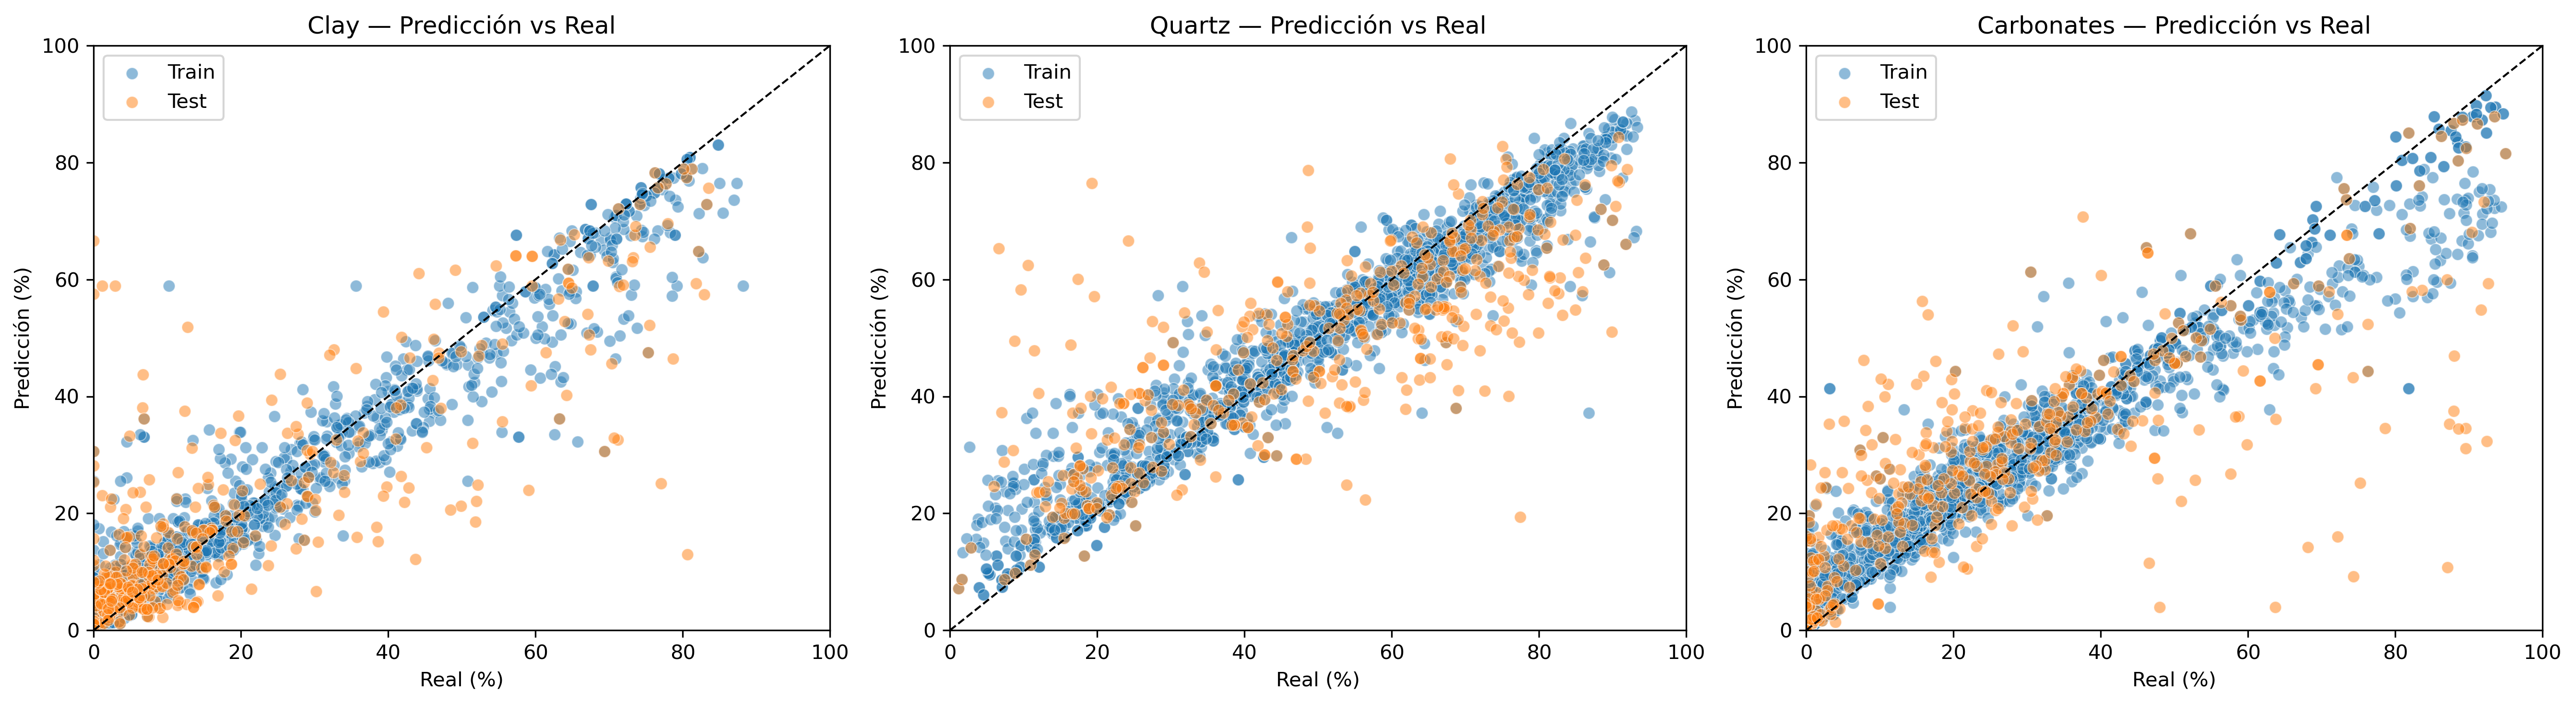

In [16]:

from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# División Train/Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modelo base
base_rf = MultiOutputRegressor(RandomForestRegressor(random_state=42))
base_rf.fit(X_train, y_train)

# Predicción
y_train_pred = base_rf.predict(X_train)
y_test_pred = base_rf.predict(X_test)

# Métricas
def print_metrics(y_true, y_pred, stage=""):
    r2 = r2_score(y_true, y_pred, multioutput='raw_values')
    mae = mean_absolute_error(y_true, y_pred, multioutput='raw_values')
    rmse = np.sqrt(mean_squared_error(y_true, y_pred, multioutput='raw_values'))
    print(f"\n📊 Métricas {stage}")
    for i, mineral in enumerate(target):
        print(f"{mineral} — R²: {r2[i]:.3f} | MAE: {mae[i]:.2f} | RMSE: {rmse[i]:.2f}")

print_metrics(y_train, y_train_pred, "ENTRENAMIENTO")
print_metrics(y_test, y_test_pred, "VALIDACIÓN")

# %% Visualización
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for i, mineral in enumerate(target):
    sns.scatterplot(x=y_train[:, i], y=y_train_pred[:, i], label='Train', ax=axes[i], alpha=0.5)
    sns.scatterplot(x=y_test[:, i], y=y_test_pred[:, i], label='Test', ax=axes[i], alpha=0.5)
    axes[i].plot([0, 100], [0, 100], 'k--', lw=1)
    axes[i].set_xlim(0, 100)
    axes[i].set_ylim(0, 100)
    axes[i].set_title(f"{mineral} — Predicción vs Real")
    axes[i].set_xlabel("Real (%)")
    axes[i].set_ylabel("Predicción (%)")
    axes[i].legend()
plt.tight_layout()
plt.show()

In [20]:
import numpy as np
import random

# Escoge un índice aleatorio del test set
idx = random.randint(0, len(y_test) - 1)

# Extrae los valores reales y predichos
real = y_test[idx]
pred = y_test_pred[idx]

# Calcula sumas y error de cierre
sum_real = np.sum(real)
sum_pred = np.sum(pred)
closure_error = abs(sum_pred - 100)

# Muestra resultados
print(f"Índice aleatorio: {idx}")
print("🔹 Valores reales     :", np.round(real, 2), f"Suma: {sum_real:.2f}%")
print("🔸 Predicción modelo  :", np.round(pred, 2), f"Suma: {sum_pred:.2f}%")
print(f"❗ Error de cierre: {closure_error:.2f}%")

Índice aleatorio: 118
🔹 Valores reales     : [ 2.93 33.35 63.72] Suma: 100.00%
🔸 Predicción modelo  : [58.89 37.13  3.98] Suma: 100.00%
❗ Error de cierre: 0.00%


In [21]:
import pandas as pd
import numpy as np

# Creamos el DataFrame de resultados
results_df = pd.DataFrame({
    'Real_Clay': y_test[:, 0],
    'Real_Quartz': y_test[:, 1],
    'Real_Carbonates': y_test[:, 2],
    'Pred_Clay': y_test_pred[:, 0],
    'Pred_Quartz': y_test_pred[:, 1],
    'Pred_Carbonates': y_test_pred[:, 2],
})

# Sumas y error de cierre
results_df['Sum_Real'] = results_df[['Real_Clay', 'Real_Quartz', 'Real_Carbonates']].sum(axis=1)
results_df['Sum_Pred'] = results_df[['Pred_Clay', 'Pred_Quartz', 'Pred_Carbonates']].sum(axis=1)
results_df['Closure_Error'] = abs(results_df['Sum_Pred'] - 100)

# Errores absolutos por mineral
results_df['MAE_Clay'] = abs(results_df['Real_Clay'] - results_df['Pred_Clay'])
results_df['MAE_Quartz'] = abs(results_df['Real_Quartz'] - results_df['Pred_Quartz'])
results_df['MAE_Carbonates'] = abs(results_df['Real_Carbonates'] - results_df['Pred_Carbonates'])

# Mostrar resumen estadístico general
print("📊 Resumen estadístico de error de cierre:")
print(results_df['Closure_Error'].describe())


📊 Resumen estadístico de error de cierre:
count    4.100000e+02
mean     3.721018e+00
std      3.844348e+00
min      1.421085e-14
25%      9.373974e-01
50%      2.407128e+00
75%      4.908742e+00
max      2.410627e+01
Name: Closure_Error, dtype: float64


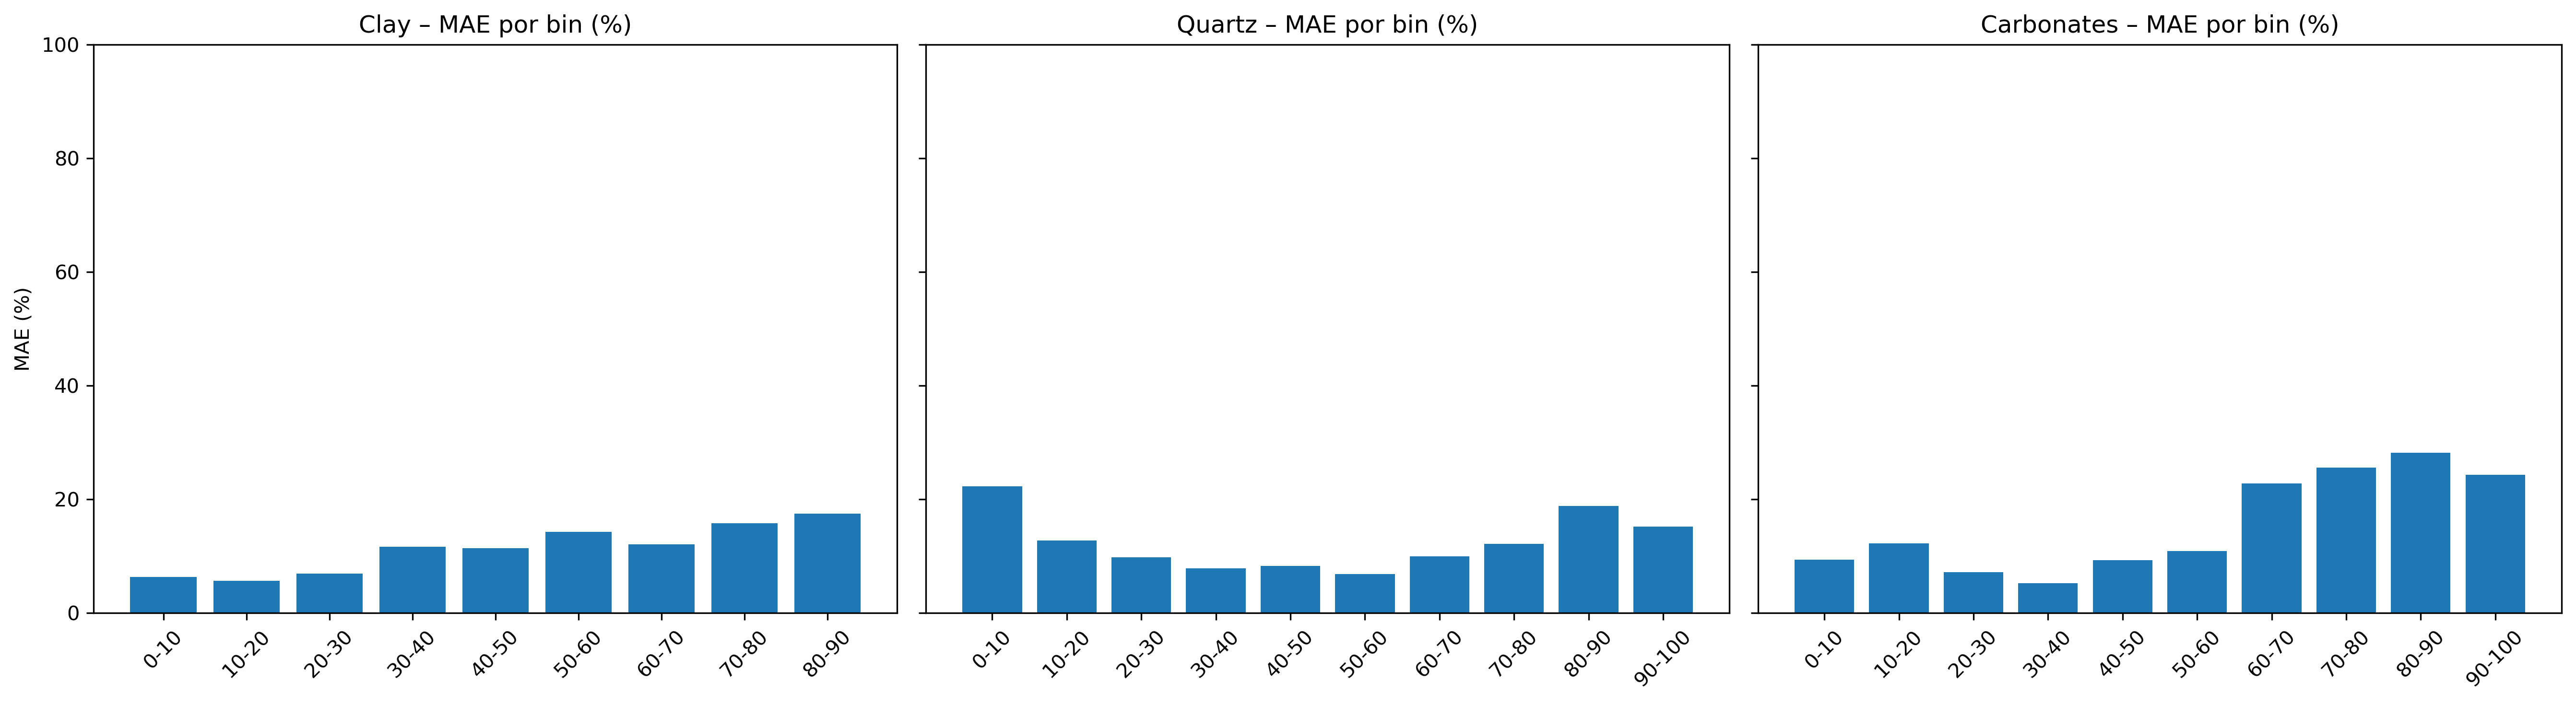

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. Crear DataFrame de resultados
results_df = pd.DataFrame(y_test, columns=['Clay_real', 'Quartz_real', 'Carbonates_real'])
results_df[['Clay_pred', 'Quartz_pred', 'Carbonates_pred']] = y_test_pred

# 2. Calcular error de cierre y error absoluto por mineral
results_df['Closure_Error'] = abs(results_df[['Clay_pred', 'Quartz_pred', 'Carbonates_pred']].sum(axis=1) - 100)
results_df['Clay_abs_error'] = abs(results_df['Clay_real'] - results_df['Clay_pred'])
results_df['Quartz_abs_error'] = abs(results_df['Quartz_real'] - results_df['Quartz_pred'])
results_df['Carbonates_abs_error'] = abs(results_df['Carbonates_real'] - results_df['Carbonates_pred'])

# 3. Definir función para agrupar por bins y calcular MAE
def mae_by_bin(real_col, abs_error_col, bin_width=10):
    bins = np.arange(0, 110, bin_width)
    labels = [f'{i}-{i+bin_width}' for i in bins[:-1]]
    binned = pd.cut(results_df[real_col], bins=bins, labels=labels, include_lowest=True)
    grouped = results_df.groupby(binned)[abs_error_col].mean()
    return grouped

# 4. Calcular MAE por bin
clay_mae_bins = mae_by_bin('Clay_real', 'Clay_abs_error')
quartz_mae_bins = mae_by_bin('Quartz_real', 'Quartz_abs_error')
carbonates_mae_bins = mae_by_bin('Carbonates_real', 'Carbonates_abs_error')

# 5. Visualización
fig, axs = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

axs[0].bar(clay_mae_bins.index.astype(str), clay_mae_bins.values)
axs[0].set_title('Clay – MAE por bin (%)')
axs[0].set_ylabel('MAE (%)')
axs[0].set_ylim(0, 100)
axs[0].set_xticklabels(clay_mae_bins.index, rotation=45)

axs[1].bar(quartz_mae_bins.index.astype(str), quartz_mae_bins.values)
axs[1].set_title('Quartz – MAE por bin (%)')
axs[1].set_ylim(0, 100)
axs[1].set_xticklabels(quartz_mae_bins.index, rotation=45)

axs[2].bar(carbonates_mae_bins.index.astype(str), carbonates_mae_bins.values)
axs[2].set_title('Carbonates – MAE por bin (%)')
axs[2].set_ylim(0, 100)
axs[2].set_xticklabels(carbonates_mae_bins.index, rotation=45)

plt.tight_layout()
plt.show()

### Hiperparámetros (train, val, test)

In [23]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# 1. División original: Train+Valid (80%) vs Test final (20%)
X_trainval, X_test_final, y_trainval, y_test_final = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 2. División secundaria: Train (64%) vs Valid (16%) → sobre el 80%
X_train, X_valid, y_train, y_valid = train_test_split(
    X_trainval, y_trainval, test_size=0.2, random_state=42
)

# 3. Concatenamos para que GridSearchCV tenga acceso a ambos
X_full = np.vstack([X_train, X_valid])
y_full = np.vstack([y_train, y_valid])

# 4. Índices para split manual
train_idx = np.arange(len(X_train))
valid_idx = np.arange(len(X_train), len(X_full))
cv_split = [(train_idx, valid_idx)]

# 5. Definimos el modelo base
rf = RandomForestRegressor(random_state=42, n_jobs=-1)
multi_rf = MultiOutputRegressor(rf)

# 6. Grid de hiperparámetros
param_grid = {
    'estimator__n_estimators': [100, 200, 300],
    'estimator__max_depth': [None, 10, 20, 30, 50],
    'estimator__min_samples_split': [2, 5, 10, 15],
    'estimator__min_samples_leaf': [1, 2, 4, 8],
    'estimator__max_features': ['auto', 'sqrt', 'log2']
}

# 7. GridSearchCV con validación fija
grid_search = GridSearchCV(
    estimator=multi_rf,
    param_grid=param_grid,
    cv=cv_split,
    scoring='r2',
    verbose=1,
    n_jobs=-1
)

# 8. Ajuste del modelo
grid_search.fit(X_full, y_full)

# 9. Resultados
best_model = grid_search.best_estimator_
print("✅ Mejores hiperparámetros encontrados:")
print(grid_search.best_params_)

# 10. Evaluación final (ciega) sobre el 20% de test
y_pred_test = best_model.predict(X_test_final)

# 11. Métricas por variable objetivo
for i, target_name in enumerate(target):  # o usa target_names si prefieres
    print(f"\n📊 Métricas para {target_name} (test ciego):")
    print(f"  R²:   {r2_score(y_test_final[:, i], y_pred_test[:, i]):.3f}")
    print(f"  MAE:  {mean_absolute_error(y_test_final[:, i], y_pred_test[:, i]):.2f}")
    print(f"  RMSE: {np.sqrt(mean_squared_error(y_test_final[:, i], y_pred_test[:, i])):.2f}")

Fitting 1 folds for each of 720 candidates, totalling 720 fits
✅ Mejores hiperparámetros encontrados:
{'estimator__max_depth': 30, 'estimator__max_features': 'log2', 'estimator__min_samples_leaf': 1, 'estimator__min_samples_split': 5, 'estimator__n_estimators': 100}

📊 Métricas para Clay (test ciego):
  R²:   0.697
  MAE:  8.28
  RMSE: 12.83

📊 Métricas para Quartz (test ciego):
  R²:   0.577
  MAE:  11.16
  RMSE: 14.84

📊 Métricas para Carbonates (test ciego):
  R²:   0.545
  MAE:  11.66
  RMSE: 16.68


In [24]:
best_params = grid_search.best_params_
print("Mejores hiperparámetros:", best_params)

Mejores hiperparámetros: {'estimator__max_depth': 30, 'estimator__max_features': 'log2', 'estimator__min_samples_leaf': 1, 'estimator__min_samples_split': 5, 'estimator__n_estimators': 100}



📊 Métricas — ENTRENAMIENTO
Clay — R²: 0.907 | MAE: 4.34 | RMSE: 6.93
Quartz — R²: 0.877 | MAE: 5.76 | RMSE: 7.94
Carbonates — R²: 0.873 | MAE: 6.03 | RMSE: 8.67

📊 Métricas — VALIDACIÓN
Clay — R²: 0.894 | MAE: 4.46 | RMSE: 6.87
Quartz — R²: 0.885 | MAE: 5.30 | RMSE: 7.88
Carbonates — R²: 0.873 | MAE: 6.08 | RMSE: 9.27

📊 Métricas — TEST FINAL (ciego)
Clay — R²: 0.697 | MAE: 8.28 | RMSE: 12.83
Quartz — R²: 0.577 | MAE: 11.16 | RMSE: 14.84
Carbonates — R²: 0.545 | MAE: 11.66 | RMSE: 16.68


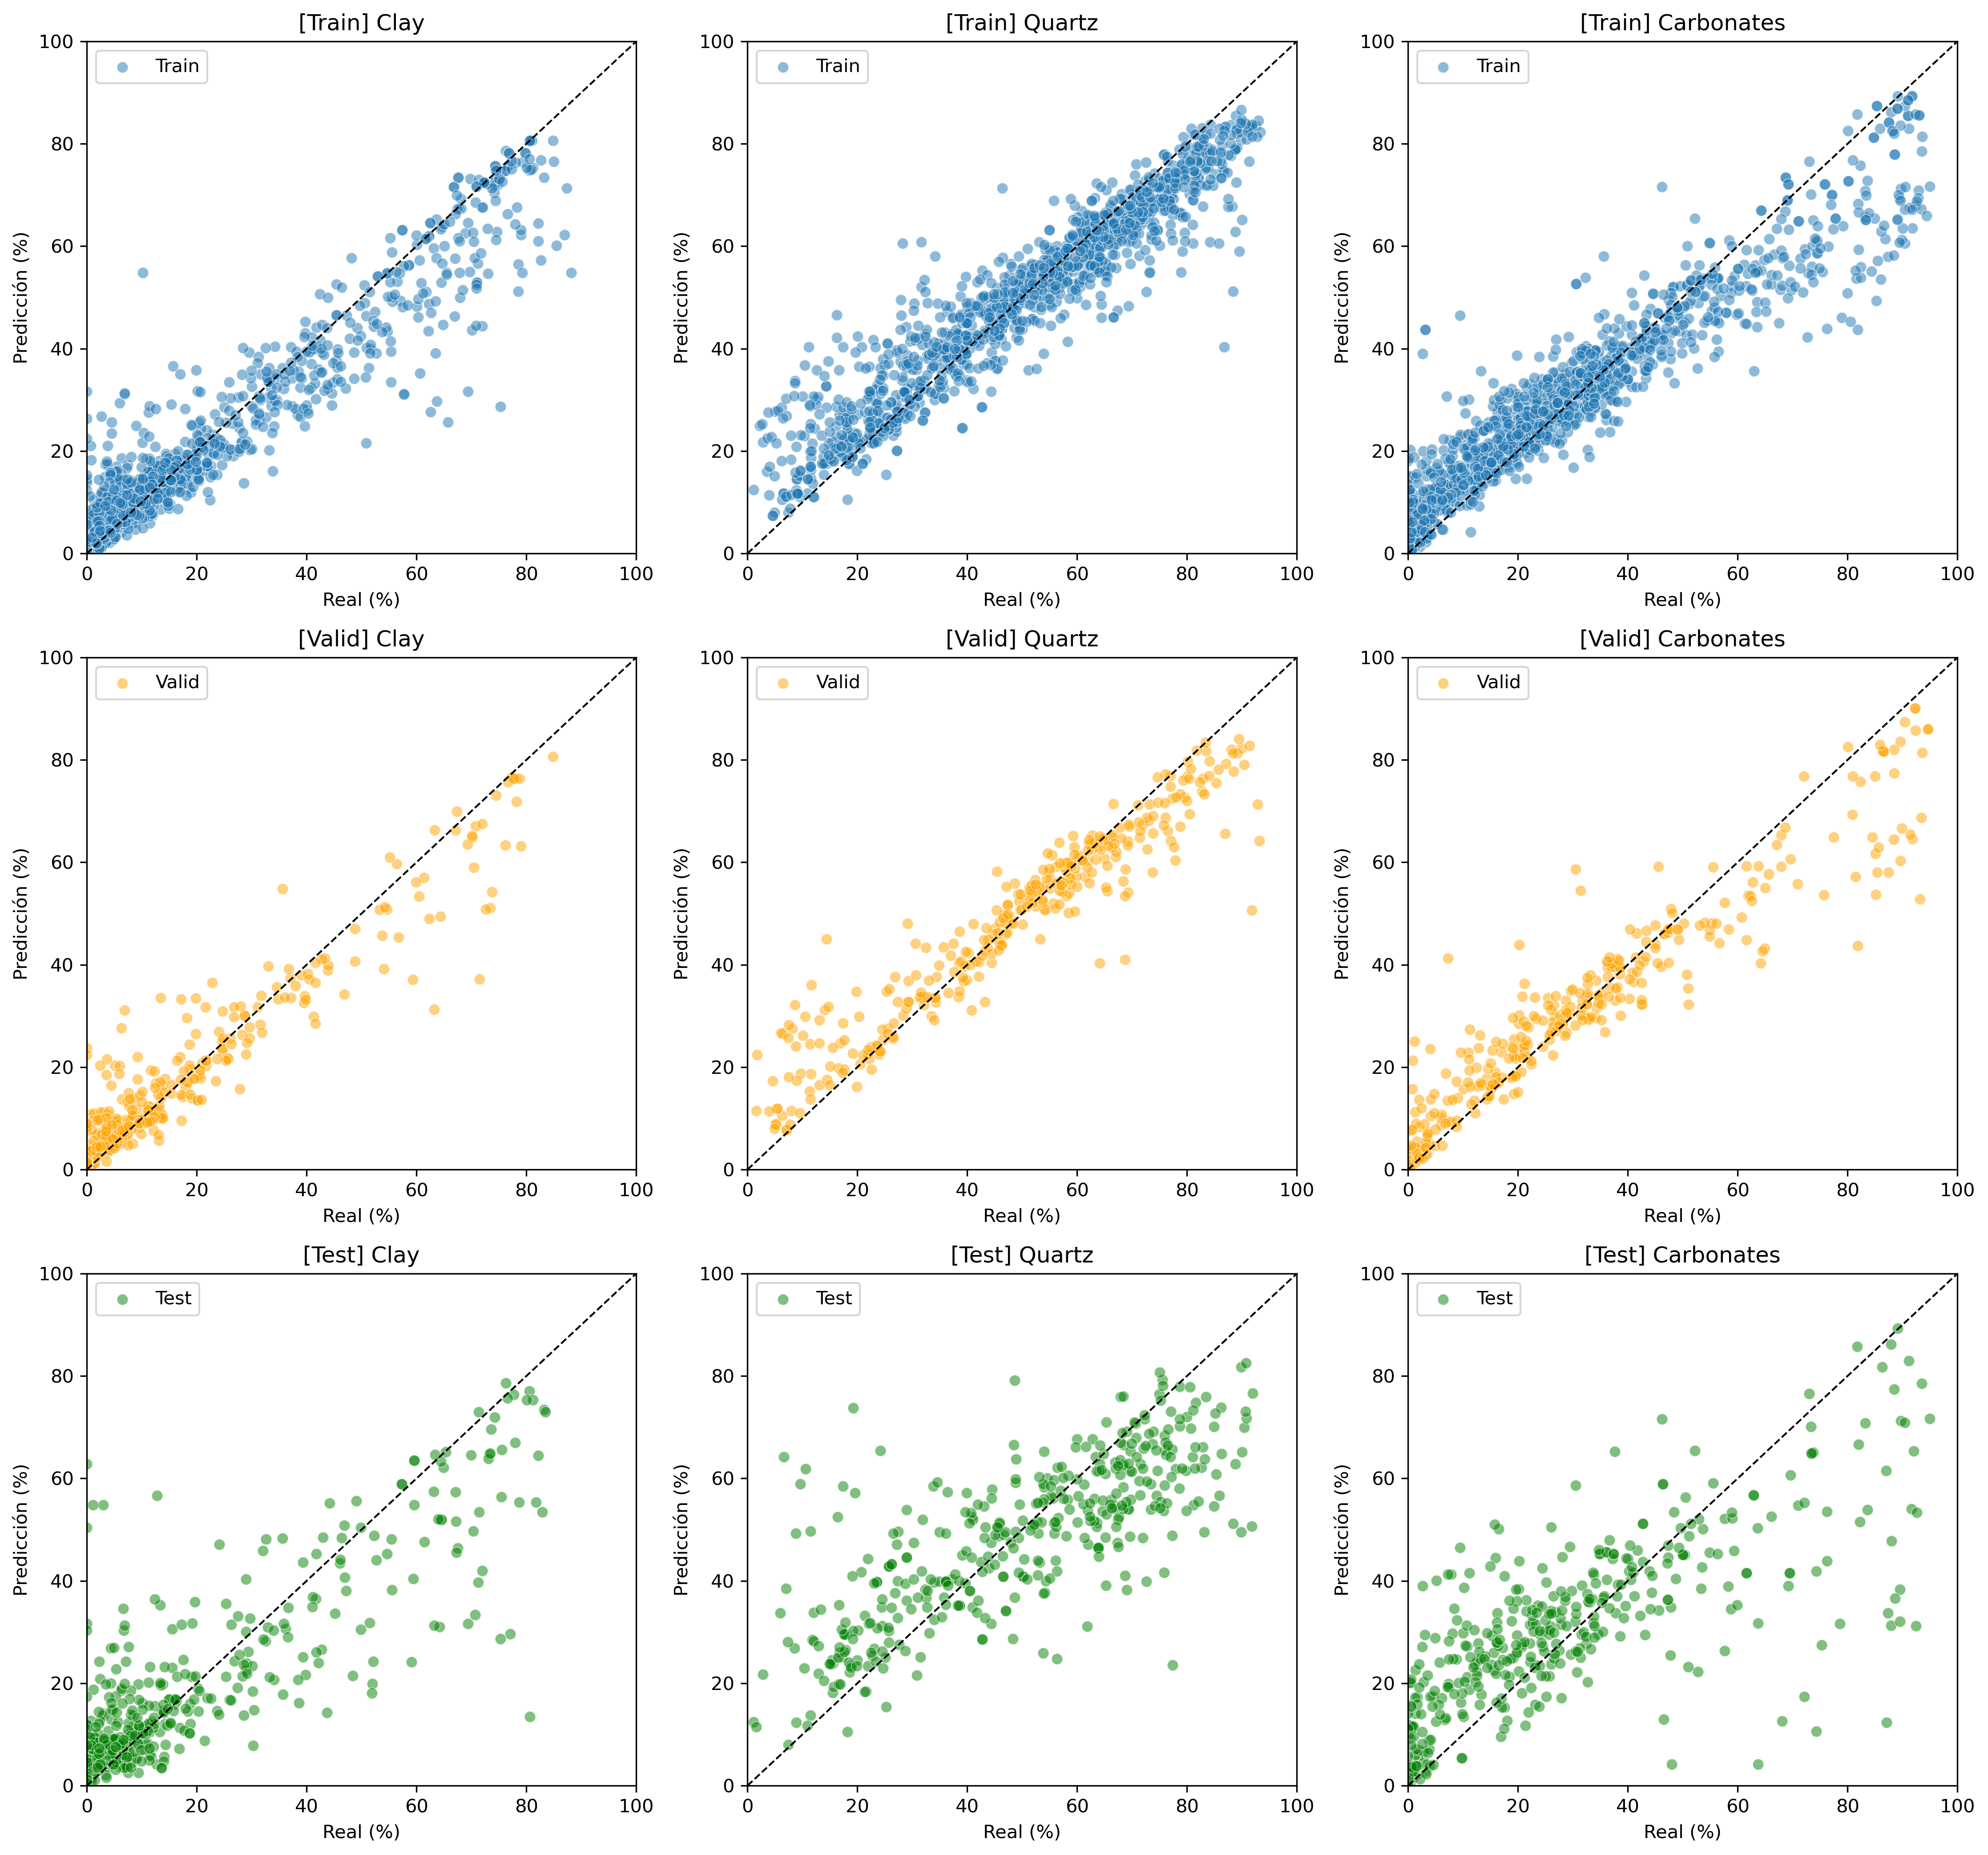

In [ ]:
# === PREDICCIONES ===
y_train_pred = best_model.predict(X_train)
y_valid_pred = best_model.predict(X_valid)
y_test_pred = best_model.predict(X_test_final)

# === FUNCIÓN DE MÉTRICAS ===
def print_metrics(y_true, y_pred, stage=""):
    r2 = r2_score(y_true, y_pred, multioutput='raw_values')
    mae = mean_absolute_error(y_true, y_pred, multioutput='raw_values')
    rmse = np.sqrt(mean_squared_error(y_true, y_pred, multioutput='raw_values'))
    print(f"\n📊 Métricas — {stage}")
    for i, mineral in enumerate(target):
        print(f"{mineral} — R²: {r2[i]:.3f} | MAE: {mae[i]:.2f} | RMSE: {rmse[i]:.2f}")

# === MÉTRICAS POR CONJUNTO ===
print_metrics(y_train, y_train_pred, "ENTRENAMIENTO")
print_metrics(y_valid, y_valid_pred, "VALIDACIÓN")
print_metrics(y_test_final, y_test_pred, "TEST FINAL (ciego)")

# === VISUALIZACIÓN PREDICCIÓN VS REAL — POR CONJUNTO ===
fig, axes = plt.subplots(3, len(target), figsize=(5 * len(target), 14))

for i, mineral in enumerate(target):
    # Train
    sns.scatterplot(x=y_train[:, i], y=y_train_pred[:, i], ax=axes[0, i], alpha=0.5, label='Train')
    axes[0, i].set_title(f"[Train] {mineral}")
    axes[0, i].plot([0, 100], [0, 100], 'k--', lw=1)

    # Valid
    sns.scatterplot(x=y_valid[:, i], y=y_valid_pred[:, i], ax=axes[1, i], alpha=0.5, label='Valid', color='orange')
    axes[1, i].set_title(f"[Valid] {mineral}")
    axes[1, i].plot([0, 100], [0, 100], 'k--', lw=1)

    # Test
    sns.scatterplot(x=y_test_final[:, i], y=y_test_pred[:, i], ax=axes[2, i], alpha=0.5, label='Test', color='green')
    axes[2, i].set_title(f"[Test] {mineral}")
    axes[2, i].plot([0, 100], [0, 100], 'k--', lw=1)

    # Ejes y etiquetas
    for j in range(3):
        axes[j, i].set_xlim(0, 100)
        axes[j, i].set_ylim(0, 100)
        axes[j, i].set_xlabel("Real (%)")
        axes[j, i].set_ylabel("Predicción (%)")
        axes[j, i].legend()

plt.tight_layout()
plt.show()

In [27]:
# === DataFrame combinado para análisis de cierre composicional ===
result_df = pd.DataFrame({
    'Clay_Real': y_test_final[:, 0],
    'Quartz_Real': y_test_final[:, 1],
    'Carbonates_Real': y_test_final[:, 2],
    'Clay_Pred': y_test_pred[:, 0],
    'Quartz_Pred': y_test_pred[:, 1],
    'Carbonates_Pred': y_test_pred[:, 2]
})

# === Cálculo del cierre y del error absoluto ===
result_df['Suma_Real'] = result_df[['Clay_Real', 'Quartz_Real', 'Carbonates_Real']].sum(axis=1)
result_df['Suma_Pred'] = result_df[['Clay_Pred', 'Quartz_Pred', 'Carbonates_Pred']].sum(axis=1)
result_df['Closure_Error'] = abs(result_df['Suma_Pred'] - result_df['Suma_Real'])

# === Estadísticas del cierre ===
print("📊 Resumen estadístico del error de cierre (%):")
print(result_df['Closure_Error'].describe())

📊 Resumen estadístico del error de cierre (%):
count    410.000000
mean       2.784177
std        2.729081
min        0.012472
25%        0.757007
50%        1.993295
75%        3.880643
max       18.560706
Name: Closure_Error, dtype: float64


In [33]:
import numpy as np
import random

# Escoge un índice aleatorio del test set
idx = random.randint(0, len(y_test_final) - 1)

# Extrae los valores reales y predichos
real = y_test_final[idx]
pred = y_test_pred[idx]

# Calcula sumas y error de cierre
sum_real = np.sum(real)
sum_pred = np.sum(pred)
closure_error = abs(sum_pred - 100)

# Muestra resultados
print(f"Índice aleatorio: {idx}")
print("🔹 Valores reales     :", np.round(real, 2), f"Suma: {sum_real:.2f}%")
print("🔸 Predicción modelo  :", np.round(pred, 2), f"Suma: {sum_pred:.2f}%")
print(f"❗ Error de cierre: {closure_error:.2f}%")

Índice aleatorio: 348
🔹 Valores reales     : [28.96 67.11  3.92] Suma: 100.00%
🔸 Predicción modelo  : [40.33 57.08  3.87] Suma: 101.28%
❗ Error de cierre: 1.28%


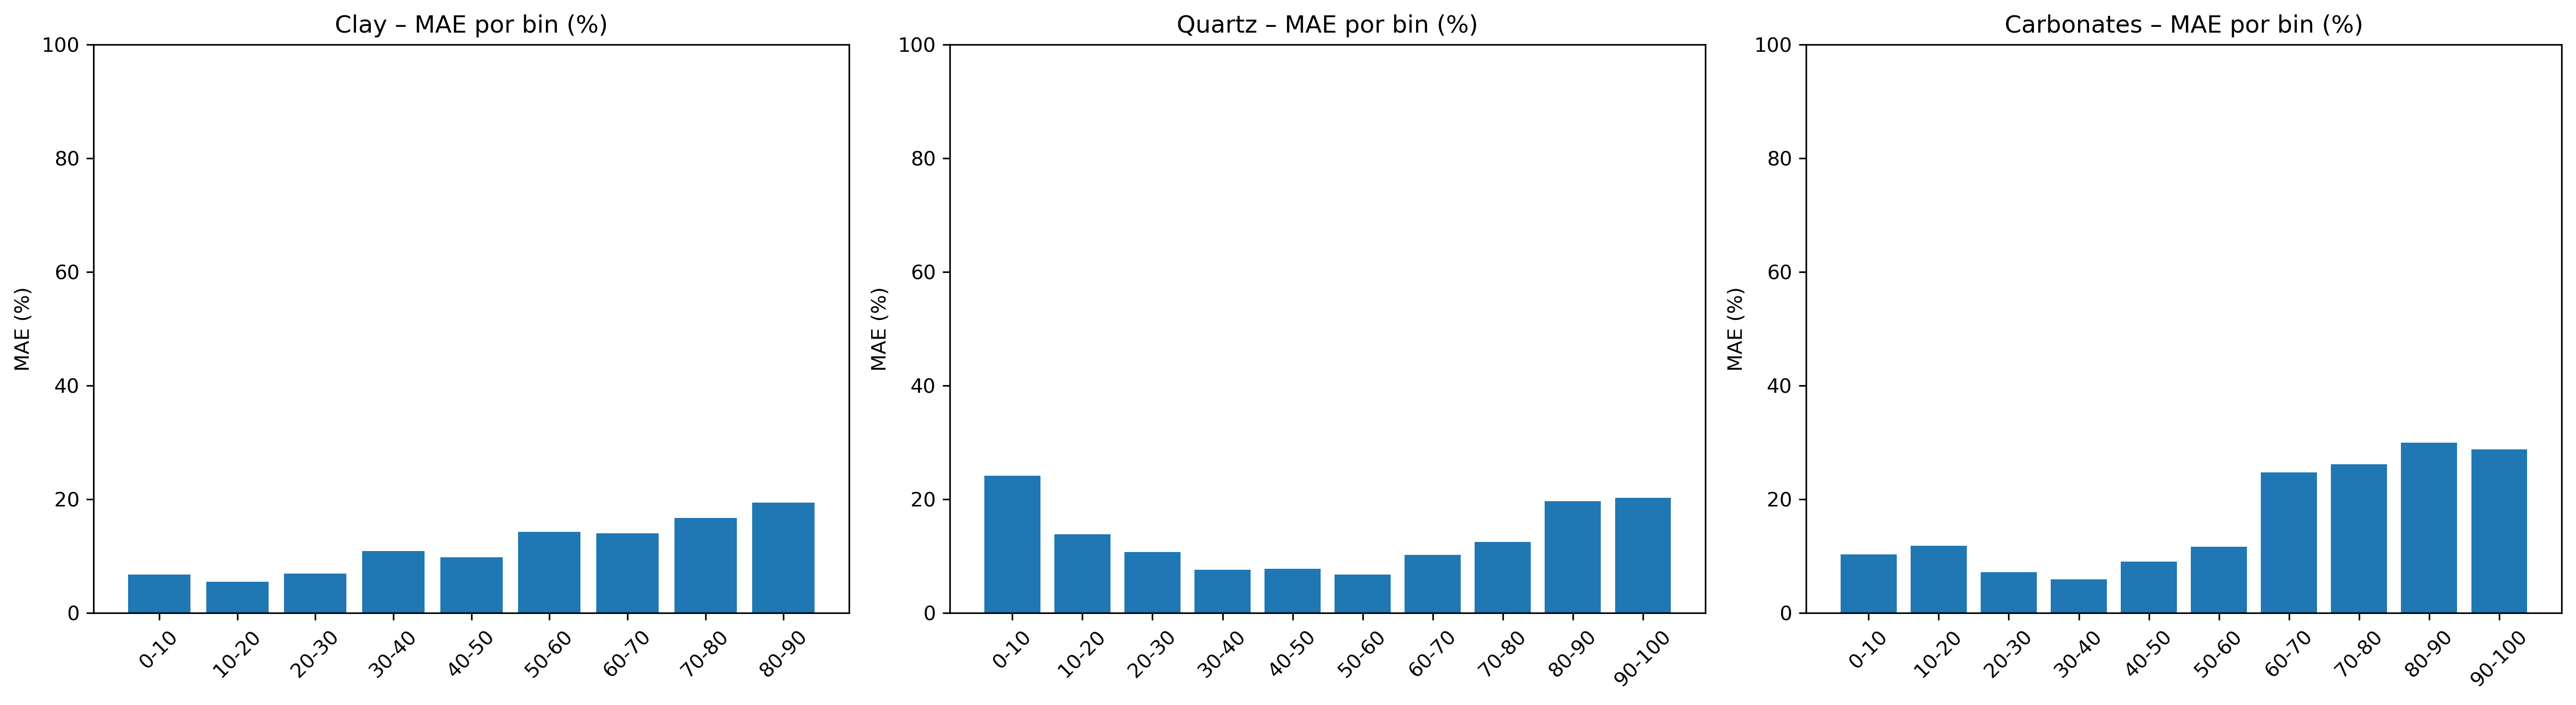

In [34]:
import matplotlib.pyplot as plt
import numpy as np

def plot_mae_by_bin(result_df, mineral):
    df = result_df.copy()  # 🔒 seguridad

    bins = np.arange(0, 101, 10)
    labels = [f'{bins[i]}-{bins[i+1]}' for i in range(len(bins)-1)]

    df[f'{mineral}_Bin'] = pd.cut(df[f'{mineral}_Real'], bins=bins, labels=labels, include_lowest=True)
    df[f'{mineral}_AbsError'] = abs(df[f'{mineral}_Pred'] - df[f'{mineral}_Real'])

    mae_by_bin = df.groupby(f'{mineral}_Bin')[f'{mineral}_AbsError'].mean()

    plt.bar(mae_by_bin.index.astype(str), mae_by_bin.values)
    plt.title(f'{mineral} – MAE por bin (%)')
    plt.ylabel('MAE (%)')
    plt.ylim(0, 100)
    plt.xticks(rotation=45)

# Gráfico por mineral
plt.figure(figsize=(18, 5))
for i, mineral in enumerate(['Clay', 'Quartz', 'Carbonates']):
    plt.subplot(1, 3, i+1)
    plot_mae_by_bin(result_df, mineral)
plt.tight_layout()
plt.show()


### Feature Engineering avanzada

In [235]:
df.columns

Index(['Depth', 'Sonic', 'GammaRay', 'NeutronPorosity', 'Resistivity',
       'Density', 'Photoelectric', 'AvgPorosity', 'RHOMAA', 'UMA', 'GR_Dens',
       'PEF_Dens', 'Clay', 'Quartz', 'Carbonates'],
      dtype='object')

In [ ]:
# Derivadas iniciales seleccionadas
logs_seleccionados = ['Sonic', 'GammaRay', 'Density', 'Resistivity']

# Ordenar por profundidad
df = df.sort_values(by='Depth').reset_index(drop=True)

# Generar solo primeras derivadas
for col in logs_seleccionados:
    df[f'{col}_d1'] = df[col].diff()

# Verificamos columnas nuevas
print(f'✅ Derivadas creadas: {[f"{col}_d1" for col in logs_seleccionados]}')
